In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/Paper Xu ly anh y khoa/"

/content/drive/MyDrive/Paper Xu ly anh y khoa


### Pre-processing: Count images and remove two error images from training set

Đếm số lượng hình ảnh

In [ ]:
import os

def count_images(folder_path):
    num_files = len([file_name for file_name in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file_name))])
    return num_files

In [ ]:
normal_folder = "data/train/normal"
positive_folder = "data/train/positive"

effusion_folder = "data_positive/train_positive/EFFUSION"
mass_folder = "data_positive/train_positive/MASS"
pneumonia_folder = "data_positive/train_positive/PNEUMONIA"
tuberculosis_folder = "data_positive/train_positive/TUBERCULOSIS"

In [ ]:
print(f"normal: {count_images(normal_folder)}")
print(f"positive: {count_images(positive_folder)}")
print(f"\neffusion: {count_images(effusion_folder)}")
print(f"mass: {count_images(mass_folder)}")
print(f"pneumonia: {count_images(pneumonia_folder)}")
print(f"tuberculosis: {count_images(tuberculosis_folder)}")

Tìm ảnh bị lỗi và xóa khỏi bộ dữ liệu

In [ ]:
from PIL import Image
import os

def verify_images(dataset_path):
    for root, dirs, files in os.walk(dataset_path):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                image = Image.open(file_path)
                image.verify()  # Verifies if the file is a valid image
            except (IOError, SyntaxError) as e:
                print(f"Error opening file: {file_path}")
                print(f"Error message: {str(e)}")
            except Exception as e:
                print(f"Unknown error occurred for file: {file_path}")
                print(f"Error message: {str(e)}")

# # Replace 'train_set_path' and 'val_set_path' with the actual paths to your training and validation datasets
# train_normal_path = 'data/train/normal'
# train_positive_path = 'data/train/positive'
# val_normal_path = 'data/val/normal'
# val_positive_path = 'data/val/positive'

# Verify dataset images
print("Verifying effusion dataset images...")
verify_images("data_positive/train_positive/EFFUSION")
verify_images("data_positive/val_positive/EFFUSION")
verify_images("data_positive/test_positive/EFFUSION")

print("\nVerifying mass dataset images...")
verify_images("data_positive/train_positive/MASS")
verify_images("data_positive/val_positive/MASS")
verify_images("data_positive/test_positive/MASS")

print("\nVerifying pneumonia dataset images...")
verify_images("data_positive/train_positive/PNEUMONIA")
verify_images("data_positive/val_positive/PNEUMONIA")
verify_images("data_positive/test_positive/PNEUMONIA")

print("\nVerifying tuberculosis dataset images...")
verify_images("data_positive/train_positive/TUBERCULOSIS")
verify_images("data_positive/val_positive/TUBERCULOSIS")
verify_images("data_positive/test_positive/TUBERCULOSIS")

Verifying effusion dataset images...

Verifying mass dataset images...

Verifying pneumonia dataset images...

Verifying tuberculosis dataset images...


In [ ]:
# Remove error file
import os
file_path_list = ["data/train/positive/person1365_virus_2348..jpg"]

for file_path in file_path_list:
    try:
      os.remove(file_path)
      print(f"File '{file_path}' removed sucessfully")
    except OSError as e:
      print(f"Error occurred while removing file '{file_path}': {str(e)}")

File 'data/train/positive/person1365_virus_2348..jpg' removed sucessfully


Đọc ảnh từ folder ảnh `image_dataset_from_directory`

In [ ]:
# train_set = tf.keras.preprocessing.image_dataset_from_directory(
#     "data/train",
#     labels = 'inferred',
#     label_mode = 'binary',
#     class_names = CLASS_NAME,
#     color_mode = COLOR_MODE,
#     batch_size = 256,
#     image_size = (100,100),
#     shuffle = True,
#     validation_split = None,
#     subset = None,
#     seed=42,
#     interpolation = 'bilinear',
# )

In [ ]:
# val_set = tf.keras.preprocessing.image_dataset_from_directory(
#           "data/val",
#           labels = "inferred",
#           label_mode = "binary",
#           class_names = CLASS_NAME,
#           color_mode = COLOR_MODE,
#           batch_size = 256,
#           image_size = (100,100),
#           shuffle = True,
#           seed = 42,
#           interpolation = "bilinear"
# )

In [ ]:
# test_set = tf.keras.preprocessing.image_dataset_from_directory(
#             "data/test",
#             labels = "inferred",
#             label_mode = "binary",
#             class_names = CLASS_NAME,
#             color_mode = COLOR_MODE,
#             batch_size = 256,
#             image_size = (100,100),
#             shuffle = True,
#             seed = 42,
#             interpolation = "bilinear"
# )

### **Phase 1:** `normal` **and** `positive` **classification**
Mục đích của việc phân loại `normal` và `positive`:
* Kiểm tra độ phủ (recall) và độ chính xác (precision).

> **Recall**: trong những người thực sự có bệnh, bao nhiêu trong số họ được dự đoán đúng bởi mô hình ? \
**Precision**: là tỷ lệ giữa những người thật sự có bệnh so với tất cả những người được dự đoán là có bệnh.

* Bài toán binary classification







In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image
import os

from keras.layers import Dense, Flatten
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam

Read images using `ImageDataGenerator`

In [ ]:
# Defining the parameters
IMG_CHANEL = 3
COLOR_MODE = 'rgb'
CLASS_NAME = ['normal', 'positive']
IMAGESHAPE = [224, 224, 3]

In [ ]:
# Function to feed data set into the model
from keras.preprocessing.image import ImageDataGenerator

## For training set
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

## For validation set and testing set
testing_datagen = ImageDataGenerator(rescale =1. / 255)

In [ ]:
# Setting folder path
train_data = 'data/train/'
val_data = 'data/val/'
test_data = 'data/test/'

In [ ]:
train_set = train_datagen.flow_from_directory(train_data,
                                              target_size = (224, 224),
                                              batch_size = 64,
                                              shuffle = True,
                                              color_mode = "rgb",
                                              class_mode = 'categorical')

Found 17369 images belonging to 2 classes.


In [ ]:
val_set = testing_datagen.flow_from_directory(val_data,
                                              target_size = (224, 224),
                                              batch_size = 64,
                                              shuffle = True,
                                              color_mode = "rgb",
                                              class_mode = 'categorical')

Found 1931 images belonging to 2 classes.


Build model

In [ ]:
inception_v3_model = InceptionV3(input_shape=IMAGESHAPE, weights='imagenet', include_top=False)

In [ ]:
for each_layer in inception_v3_model.layers:
		each_layer.trainable = False

In [ ]:
# Flatten output
flatten_layer = Flatten()(inception_v3_model.output)
prediction = Dense(len(CLASS_NAME), activation='softmax')(flatten_layer)

In [ ]:
final_model = Model(inputs=inception_v3_model.input, outputs=prediction)
final_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_188 (Conv2D)            (None, 111, 111, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_188 (Batch  (None, 111, 111, 32  96         ['conv2d_188[0][0]']             
 Normalization)                 )                                                           

In [ ]:
# Compile model
final_model.compile(
      loss='categorical_crossentropy',
      optimizer='adam',
      metrics=['accuracy']
)

In [ ]:
# Train model
fitted_model = final_model.fit_generator(generator = train_set,
                                         validation_data = val_set,
                                         epochs=10,
                                         steps_per_epoch=len(train_set),
                                         validation_steps=len(val_set)
                                        )

<ipython-input-51-6c19f3e4afa6>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fitted_model = final_model.fit_generator(generator = train_set,


Epoch 1/10
272/272 [==============================] - 1132s 4s/step - loss: 1.2472 - accuracy: 0.7283 - val_loss: 0.7545 - val_accuracy: 0.7421
Epoch 2/10
272/272 [==============================] - 499s 2s/step - loss: 1.0360 - accuracy: 0.7536 - val_loss: 0.7016 - val_accuracy: 0.8006
Epoch 3/10
272/272 [==============================] - 514s 2s/step - loss: 1.1430 - accuracy: 0.7650 - val_loss: 0.9722 - val_accuracy: 0.7519
Epoch 4/10
272/272 [==============================] - 502s 2s/step - loss: 1.0315 - accuracy: 0.7754 - val_loss: 1.0314 - val_accuracy: 0.7954
Epoch 5/10
272/272 [==============================] - 505s 2s/step - loss: 1.0069 - accuracy: 0.7818 - val_loss: 0.9113 - val_accuracy: 0.7809
Epoch 6/10
272/272 [==============================] - 492s 2s/step - loss: 1.0394 - accuracy: 0.7784 - val_loss: 1.1746 - val_accuracy: 0.7727
Epoch 7/10
272/272 [==============================] - 484s 2s/step - loss: 1.0208 - accuracy: 0.7876 - val_loss: 0.8744 - val_accuracy: 0.800

In [ ]:
# Save model
final_model.save('saved_model/inception_v3_normal_positive_size224.h5')

#### Load saved model and predict on test set

In [ ]:
test_data = 'data/test/'

from keras.preprocessing.image import ImageDataGenerator
## For validation set and testing set
testing_datagen = ImageDataGenerator(rescale =1. / 255)

In [ ]:
test_set = testing_datagen.flow_from_directory(test_data,
                                               target_size = (224, 224),
                                               batch_size = 64,
                                               shuffle = False,
                                               color_mode = "rgb",
                                               class_mode = 'categorical')

Found 4827 images belonging to 2 classes.


In [ ]:
from keras.models import load_model
# Load model
model=load_model('/content/drive/MyDrive/Paper Xu ly anh y khoa/saved_model/inception_v3_normal_positive_size224.h5')
prediction=model.predict(test_set)

76/76 [==============================] - 722s 10s/step


In [ ]:
# Convert y_pred to binary
y_pred = []
for i in range(0,len(prediction)):
    if prediction[i][0]>prediction[i][1]:
        y_pred.append(0)
    else:
        y_pred.append(1)
print(y_pred)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 

In [ ]:
# Convert y_true to list
y_true = test_set.classes.tolist()

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
report = classification_report(y_true, y_pred, digits=4, output_dict=True)
print(classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.6750    0.8751    0.7622      1970
           1     0.8918    0.7095    0.7903      2857

    accuracy                         0.7771      4827
   macro avg     0.7834    0.7923    0.7762      4827
weighted avg     0.8033    0.7771    0.7788      4827



In [ ]:
# Convert the report to a DataFrame
df = pd.DataFrame(report).transpose()

# Save the DataFrame to a CSV file
df.to_csv('report_inception_normal_positive_size224.csv', index=True)

In [ ]:
print(confusion_matrix(y_true, y_pred))

[[1724  246]
 [ 830 2027]]


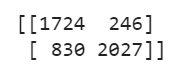

In [ ]:
plot.plot(model.history['loss'], label='training loss') #Plotting the accuracies
plot.plot(model.history['val_loss'], label='validation loss')
plot.legend()
plot.show()
# plot.savefig('LossVal_loss')
plot.plot(model.history['accuracy'], label='training accuracy')
plot.plot(model.history['val_accuracy'], label='validation accuracy')
plot.legend()
plot.show()
# plot.savefig('AccVal_acc')

### **Phase 2:** Phân loại 4 bệnh


* Bài toán multi-classification







In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image
import os

from keras.layers import Dense, Flatten
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam

Read images using `ImageDataGenerator`

In [ ]:
# Defining the parameters
IMG_CHANEL = 3
COLOR_MODE = 'rgb'
CLASS_NAME = ['TUBERCULOSIS', 'PNEUMONIA', 'MASS', 'EFFUSION']
IMAGESHAPE = [224, 224, 3]

In [ ]:
# Function to feed data set into the model
from keras.preprocessing.image import ImageDataGenerator

## For training set
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

## For validation set and testing set
testing_datagen = ImageDataGenerator(rescale =1. / 255)

In [ ]:
# Setting folder path
train_data = 'data_positive/train_positive/'
val_data = 'data_positive/val_positive/'
test_data = 'data_positive/test_positive/'

In [ ]:
train_set = train_datagen.flow_from_directory(train_data,
                                              target_size = (224, 224),
                                              batch_size = 64,
                                              shuffle = True,
                                              color_mode = "rgb",
                                              class_mode = 'categorical')

Found 10286 images belonging to 4 classes.


In [ ]:
val_set = testing_datagen.flow_from_directory(val_data,
                                              target_size = (224, 224),
                                              batch_size = 64,
                                              shuffle = True,
                                              color_mode = "rgb",
                                              class_mode = 'categorical')

Found 1145 images belonging to 4 classes.


Build model

In [ ]:
inception_v3_model = InceptionV3(input_shape=IMAGESHAPE, weights='imagenet', include_top=False)

87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
for each_layer in inception_v3_model.layers:
		each_layer.trainable = False

In [ ]:
# Flatten output
flatten_layer = Flatten()(inception_v3_model.output)
prediction = Dense(len(CLASS_NAME), activation='softmax')(flatten_layer)

In [ ]:
final_model = Model(inputs=inception_v3_model.input, outputs=prediction)
final_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
# Compile model
final_model.compile(
      loss='categorical_crossentropy',
      optimizer='adam',
      metrics=['accuracy']
)

In [ ]:
# Train model
fitted_model = final_model.fit_generator(generator = train_set,
                                         validation_data = val_set,
                                         epochs=10,
                                         steps_per_epoch=len(train_set),
                                         validation_steps=len(val_set)
                                        )

<ipython-input-19-6c19f3e4afa6>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  fitted_model = final_model.fit_generator(generator = train_set,


Epoch 1/10
161/161 [==============================] - 1740s 11s/step - loss: 1.1523 - accuracy: 0.7889 - val_loss: 1.1267 - val_accuracy: 0.7633
Epoch 2/10
161/161 [==============================] - 1683s 10s/step - loss: 1.0763 - accuracy: 0.8097 - val_loss: 1.7582 - val_accuracy: 0.7258
Epoch 3/10
161/161 [==============================] - 1721s 11s/step - loss: 0.9924 - accuracy: 0.8304 - val_loss: 1.9375 - val_accuracy: 0.7066
Epoch 4/10
161/161 [==============================] - 1688s 10s/step - loss: 1.2993 - accuracy: 0.8211 - val_loss: 1.8413 - val_accuracy: 0.7930
Epoch 5/10
161/161 [==============================] - 1731s 11s/step - loss: 1.0277 - accuracy: 0.8453 - val_loss: 1.2372 - val_accuracy: 0.8279
Epoch 6/10
116/161 [====================>.........] - ETA: 7:07 - loss: 1.1417 - accuracy: 0.8484

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-6c19f3e4afa6>", line 2, in <cell line: 2>
    fitted_model = final_model.fit_generator(generator = train_set,
  File "/usr/local/lib/python3.10/dist-packages/keras/engine/training.py", line 2636, in fit_generator
    return self.fit(
  File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/eager/execute.py", line 52, in quick_execute
    tensors = pywrap_tfe.TFE_Py_Execute(ctx._handle, device_name, op_name,
tensorflow.python.framework.errors_impl.UnknownError: Graph execution error:

OSError: [Errno 107] Transport endpoint is not connected: 'data_positive/train_positive/EFFUSION/00006298_005.jpg'
Traceback

In [ ]:
# Save model
final_model.save('saved_model/inception_v3_multi_positive_size224.h5')

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-705ae0dd08b8>", line 2, in <cell line: 2>
    final_model.save('saved_model/inception_v3_multi_positive_size224.h5')
  File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/lib/io/file_io.py", line 513, in recursive_create_dir_v2
    _pywrap_file_io.RecursivelyCreateDir(compat.path_to_bytes(path))
tensorflow.python.framework.errors_impl.FailedPreconditionError: saved_model; Transport endpoint is not connected

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, 

#### Load saved model and predict on test set

In [ ]:
test_data = 'data/test/'

from keras.preprocessing.image import ImageDataGenerator
## For validation set and testing set
testing_datagen = ImageDataGenerator(rescale =1. / 255)

In [ ]:
test_set = testing_datagen.flow_from_directory(test_data,
                                               target_size = (224, 224),
                                               batch_size = 64,
                                               shuffle = False,
                                               color_mode = "rgb",
                                               class_mode = 'categorical')

Found 4827 images belonging to 2 classes.


In [ ]:
from keras.models import load_model
# Load model
model=load_model('/content/drive/MyDrive/Paper Xu ly anh y khoa/saved_model/inception_v3_normal_positive_size224.h5')
prediction=model.predict(test_set)

76/76 [==============================] - 722s 10s/step


In [ ]:
# Convert y_pred to binary
y_pred = []
for i in range(0,len(prediction)):
    if prediction[i][0]>prediction[i][1]:
        y_pred.append(0)
    else:
        y_pred.append(1)
print(y_pred)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 

In [ ]:
# Convert y_true to list
y_true = test_set.classes.tolist()

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
report = classification_report(y_true, y_pred, digits=4, output_dict=True)
print(classification_report(y_true, y_pred, digits=4))

              precision    recall  f1-score   support

           0     0.6750    0.8751    0.7622      1970
           1     0.8918    0.7095    0.7903      2857

    accuracy                         0.7771      4827
   macro avg     0.7834    0.7923    0.7762      4827
weighted avg     0.8033    0.7771    0.7788      4827



In [ ]:
# Convert the report to a DataFrame
df = pd.DataFrame(report).transpose()

# Save the DataFrame to a CSV file
df.to_csv('report_inception_normal_positive_size224.csv', index=True)

In [ ]:
print(confusion_matrix(y_true, y_pred))

[[1724  246]
 [ 830 2027]]


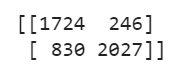

In [ ]:
plot.plot(model.history['loss'], label='training loss') #Plotting the accuracies
plot.plot(model.history['val_loss'], label='validation loss')
plot.legend()
plot.show()
# plot.savefig('LossVal_loss')
plot.plot(model.history['accuracy'], label='training accuracy')
plot.plot(model.history['val_accuracy'], label='validation accuracy')
plot.legend()
plot.show()
# plot.savefig('AccVal_acc')